In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import numpy as np
import tensorflow as tf

from keras_yolo.model import Yolo
from keras_yolo.preprocessing import parse_annotation, BatchGenerator
from keras_yolo.utils import WeightReader

Using TensorFlow backend.


In [4]:
ANCHORS = [
    [1, 1],
    [1, 1.5],
    [1.5, 1],
    [3, 3],
    [1.5, 4],
    [4, 1.5]
]

MAX_TRAIN_BOXES = 10

# Load the training data
We parse the PASCAL VOC definitions of the images to a format we can handle. Next, we define a generator to prepare input and output data for our network.

In [5]:
image_path = '/content/data/images/'
annot_path = '/content/data/annotations/'

all_imgs, seen_labels = parse_annotation(annot_path, image_path)

labels = list(seen_labels.keys())
label_mapping = dict((label, index) for index, label in enumerate(labels))

print("We have seen the following labels (format: label, counts): {}".format(seen_labels))

We have seen the following labels (format: label, counts): {'raccoon': 217}


In [6]:
from sklearn.model_selection import train_test_split

train_imgs, test_imgs = train_test_split(all_imgs, test_size=20)

# Define the generator used for training
train_generator = BatchGenerator(train_imgs, 5, label_mapping, len(ANCHORS), MAX_TRAIN_BOXES)
test_generator = BatchGenerator(test_imgs, 5, label_mapping, len(ANCHORS), MAX_TRAIN_BOXES, shuffle=False)

# Define the model and load pretrained weights.

In [9]:
yolo = Yolo(len(labels), anchors=ANCHORS, max_boxes=MAX_TRAIN_BOXES)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


We will set the model using the pretrained weights downloaded form the YOLO website.

In [10]:
wt_path = '/content/weights/yolo.weights'
weight_reader = WeightReader(wt_path)

weight_reader.reset()
nb_conv = 22

for i in range(1, nb_conv+1):
    conv_layer = yolo.get_layer('conv_' + str(i))
    
    if i < nb_conv:
        norm_layer = yolo.get_layer('norm_' + str(i))
        
        size = np.prod(norm_layer.get_weights()[0].shape)

        beta  = weight_reader.read_bytes(size)
        gamma = weight_reader.read_bytes(size)
        mean  = weight_reader.read_bytes(size)
        var   = weight_reader.read_bytes(size)

        weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
    if len(conv_layer.get_weights()) > 1:
        bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel, bias])
    else:
        kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
        kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
        kernel = kernel.transpose([2,3,1,0])
        conv_layer.set_weights([kernel])

### Test the basic structure of the model
To test the basic structure of the model we make a few dummy predictions. This should give us an idea whether all values are properly normalized and whether the model graph is correctly constructed.

In [11]:
from keras.optimizers import Adam
optimizer = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
yolo.compile(optimizer, yolo.loss)

In [49]:
yolo.fit_generator(generator=train_generator, steps_per_epoch=len(train_imgs)/5, 
                   epochs=30, verbose=1, max_queue_size=3)

Epoch 1/30
36/36 [==============================] - 17s 480ms/step - loss: 0.1503
Epoch 2/30
36/36 [==============================] - 17s 476ms/step - loss: 0.1615
Epoch 3/30
36/36 [==============================] - 17s 474ms/step - loss: 0.1667
Epoch 4/30
36/36 [==============================] - 17s 477ms/step - loss: 0.1498
Epoch 5/30
36/36 [==============================] - 17s 474ms/step - loss: 0.1510
Epoch 6/30
36/36 [==============================] - 17s 475ms/step - loss: 0.1400
Epoch 7/30
36/36 [==============================] - 17s 476ms/step - loss: 0.1322
Epoch 8/30
36/36 [==============================] - 17s 476ms/step - loss: 0.1189
Epoch 9/30
36/36 [==============================] - 17s 477ms/step - loss: 0.1198
Epoch 10/30
36/36 [==============================] - 17s 478ms/step - loss: 0.1223
Epoch 11/30
36/36 [==============================] - 17s 471ms/step - loss: 0.1107
Epoch 12/30
36/36 [==============================] - 17s 478ms/step - loss: 0.1191
Epoch 13/30
3

In [81]:
batch = 0
x, y = test_generator[batch]
y_pred_np = yolo.predict(x)

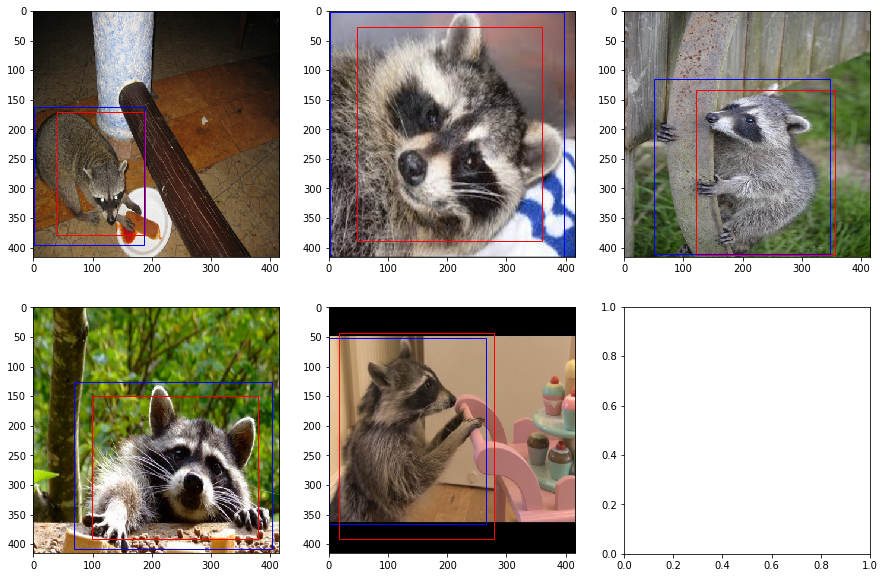

In [82]:
%matplotlib inline
import cv2
from skimage.transform import resize
from keras_yolo.utils import non_max_suppression
import matplotlib.pyplot as plt
from matplotlib import patches

def to_xy(output):
    xy = output[:, 0:2]
    wh = output[:, 2:4]
    
    return np.hstack([xy-0.5*wh, xy+0.5*wh])

fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(15,10))

for img, ax in enumerate(np.reshape(axs, (-1,))):
    if img >= 5:
        break
        
    msk = y_pred_np[img, :, :, :, 0, 4] > 0.6

    boxes = y_pred_np[img, msk][:, 0, 0:4]
    boxes = to_xy(boxes)
    probs = y_pred_np[img, msk][:, 0, 4]

    filename = test_imgs[(5*batch) + img]['filename']
    image_array = resize(cv2.imread(filename), Yolo.INPUT_SIZE, mode='constant')
    supressed_boxes = non_max_suppression(boxes, probs=probs, overlapThresh=0.3)
    true_boxes = to_xy(y[img, 0, 0, 0, :, 0:4])

    # Display the image
    ax.imshow(image_array[..., [2,1,0]])

    for box in supressed_boxes:
        grid_h, grid_w = Yolo.GRID_SIZE
        w, h = Yolo.INPUT_SIZE
        x_min = (box[0] / grid_w) * w
        y_min = (box[1] / grid_h) * h
        x_max = (box[2] / grid_w) * w
        y_max = (box[3] /grid_h) * h

        width = x_max - x_min
        height = y_max - y_min
        patch = patches.Rectangle((x_min, y_min), width, height ,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(patch)

    for box in true_boxes:
        grid_h, grid_w = Yolo.GRID_SIZE
        w, h = Yolo.INPUT_SIZE
        x_min = (box[0] / grid_w) * w
        y_min = (box[1] / grid_h) * h
        x_max = (box[2] / grid_w) * w
        y_max = (box[3] /grid_h) * h

        width = x_max - x_min
        height = y_max - y_min
        patch = patches.Rectangle((x_min, y_min), width, height ,linewidth=1,edgecolor='b',facecolor='none')
        ax.add_patch(patch)

In [83]:
from keras_yolo.utils import non_max_suppression

In [11]:
y_pred_np.shape

(5, 13, 13, 6, 10, 6)

In [40]:
y_true = tf.constant(y.astype('float32'))
y_pred = tf.constant(y_pred_np.astype('float32'))

In [43]:
xy_true = y_true[..., 0:2]
wh_true = y_true[..., 2:4]

xy_pred = y_pred[..., 0:2]
wh_pred = y_pred[..., 2:4]

conf_pred = y_pred[..., 5]

In [50]:
base_boxes = yolo.pad_base_boxes_for_loss(add_noise=False)
anchors_iou = Yolo.compute_iou(y_true, base_boxes)
predictions_iou = Yolo.compute_iou(y_true, y_pred)


In [51]:
anchors_iou

<tf.Tensor 'truediv_2:0' shape=(5, 13, 13, 6, 10) dtype=float32>

In [83]:
anchors_mask = yolo.build_iou_mask(anchors_iou + tie_breaker)

In [56]:
anchors_iou

<tf.Tensor 'truediv_2:0' shape=(5, 13, 13, 6, 10) dtype=float32>

In [57]:
base_boxes

<tf.Tensor 'Tile_13:0' shape=(13, 13, 6, 10, 4) dtype=float32>

In [77]:
y.shape

(5, 13, 13, 6, 10, 6)

In [85]:
tie_breaker = -0.0001 * tf.norm(xy_true - base_boxes[..., 0:2], axis=-1)

In [84]:
simple_eval(anchors_mask).sum()

5

In [267]:
xy_true_masked = tf.boolean_mask(xy_true, anchors_mask)
wh_true_masked = tf.boolean_mask(wh_true, anchors_mask)

xy_pred_masked = tf.boolean_mask(xy_pred, anchors_mask)
wh_pred_masked = tf.boolean_mask(wh_pred, anchors_mask)



In [270]:
xy_loss = tf.reduce_mean(tf.squared_difference(xy_true_masked, xy_pred_masked))
wh_loss = tf.reduce_mean(
    tf.squared_difference(tf.sqrt(wh_true_masked), tf.sqrt(wh_pred_masked)))

coord_los = xy_loss + wh_loss

In [281]:
conf_pred_masked = tf.boolean_mask(conf_pred, anchors_mask | predictions_mask)
true_confs_masked = tf.boolean_mask(predictions_iou, anchors_mask | predictions_mask)
conf_loss = tf.reduce_mean(tf.squared_difference(true_confs, true_confs_masked))

<tf.Tensor 'Mean_6:0' shape=() dtype=float32>

In [276]:
conf_pred_masked

<tf.Tensor 'boolean_mask_8/GatherV2:0' shape=(?,) dtype=float32>

In [258]:
anchors_iou

<tf.Tensor 'truediv_34:0' shape=(5, 13, 13, 4, 10) dtype=float32>

In [257]:
xy_pred

<tf.Tensor 'strided_slice_364:0' shape=(5, 13, 13, 4, 10, 2) dtype=float32>

In [217]:
anchors_iou = compute_iou(y_true, base_boxes_true)
predictions_iou = compute_iou(y_true, y_pred)

In [204]:
max_anchors_iou = tf.tile(tf.reduce_max(anchors_iou, axis=[1,2,3], keepdims=True),
                          [1, GRID_H, GRID_W, len(ANCHORS), 1])

In [206]:
anchors_iou_msk = (anchors_iou >= max_anchors_iou) & (max_anchors_iou > 0)

In [208]:
simple_eval(tf.cast(anchors_iou_msk, 'float32')).sum()

6.0

In [ ]:
iou = 

In [ ]:
simple_eval(iou).max()

In [68]:
wh_true * [0.5, -0.5]

<tf.Tensor 'mul_35:0' shape=(5, 13, 13, 4, 10, 2) dtype=float32>

In [83]:
a = tf.constant([[1., 2.], [3., 4.]])

In [84]:
simple_eval(a * [-1. , 1.])

array([[-1.,  2.],
       [-3.,  4.]], dtype=float32)